# Experiment 02: Influence of weight coefficients

In [1]:
%matplotlib inline

import os
import sys
import copy
import time
import pickle
from array import array
import numpy as np
np.seterr(over='ignore')
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy import optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, FloatSlider

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

## Loading data 2D

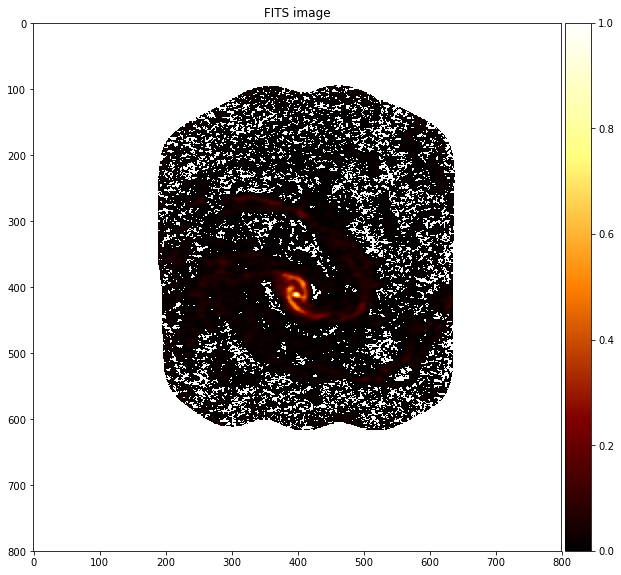

In [2]:
"""
Loading data
"""

fits_path = '../data/images/M100_combine_CO_cube.image.mom0.pbcor.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [3]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

/home/mavillan/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:3902: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  check = self.filled(0).__eq__(other)


<function graph.thresholded_image_plot>

## `Case 1 `:   $\alpha_1 \in [0,10]$

In [ ]:
elm_list = list()
alpha1 = np.arange(0.,10.1,0.25)

for a1 in alpha1:
    # common parameters
    minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
    maxsig = 30*minsig

    # number of points of each type
    Nc = 300
    Nb = int(0.2*Nc)
    Ne = 3*Nc - Nb
    
    # points generation
    points = qrandom_centers_generation(dfunc, Nc+Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[Nc:Nc+Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)

    # right format
    xc = center_points[:,0]
    yc = center_points[:,1]
    xe = collocation_points[:,0]
    ye = collocation_points[:,1]
    xb = boundary_points[:,0]
    yb = boundary_points[:,1]

    ## visualizing the choosen points
    #points_plot(data, center_points=center_points, title="Center Points")
    #points_plot(data, center_points=collocation_points, title="Collocation Points")


    ####################################
    # Initial parameters estimation
    ####################################
    c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')


    #solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
    #params_plot(c0, sig0, xc, yc)
    #params_distribution_plot(c0, sig0)
    elm_list.append( ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=a1, lamb1=1., b=0., lamb2=1.,
                    d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.) )

../lib/points_generation.py:128: RuntimeWarning: invalid value encountered in greater
  pixel_map = data > base_level
../lib/variational.py:79: RuntimeWarning: invalid value encountered in greater
  self.mask = data > base_level


##########################################################################################
Processing example with alpha1: 0.0
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 120100.
nfev: 120110

Residual stats:
Residual RMS: 0.02328562364124139
Residual Variance: 0.0005417625048655978
Flux Lost: 0.06501226909063897
Flux Addition: 0.07164817224378904
psi1(u-f): 2.268247061039632
Exceeded Pixels: 7148
Sharpness: 167.80125170472976
psi2(grad u): 1.9618403971930893
Total elapsed time: 381.9251756668091 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.06490820241469882
Mean min distance between collocation and cent

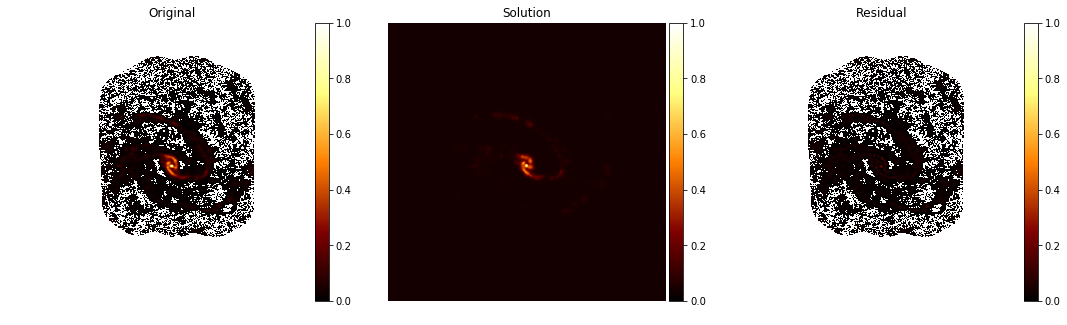

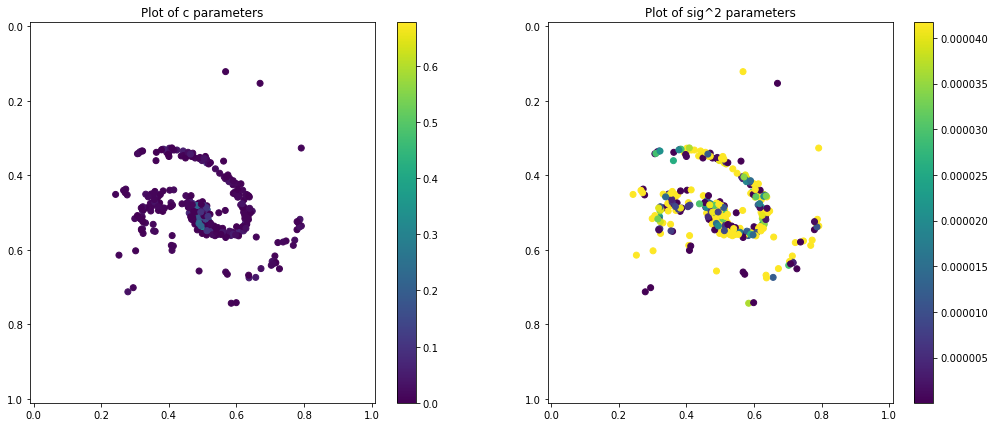

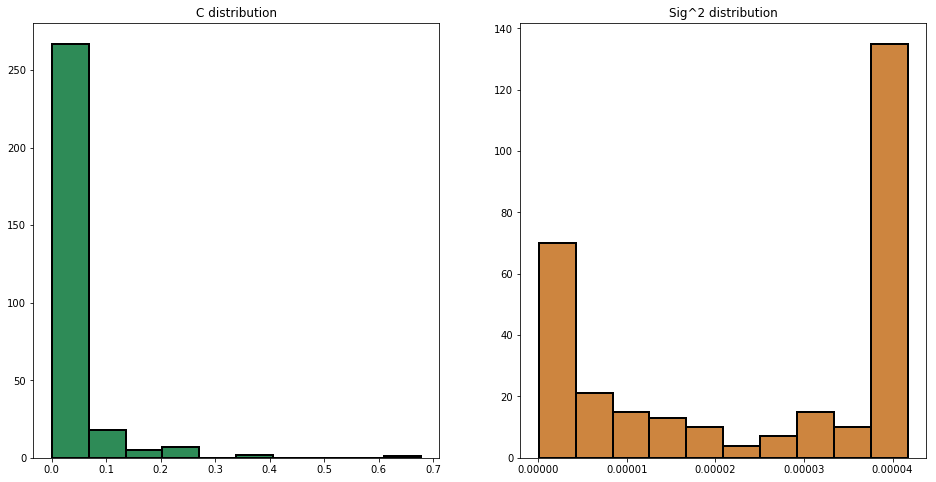

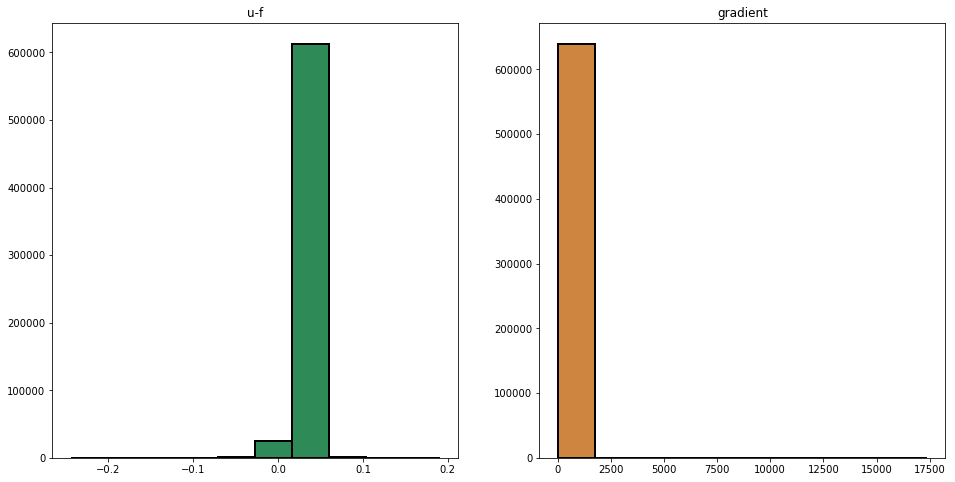

##########################################################################################
Processing example with alpha1: 0.25
##########################################################################################



In [ ]:
for elm in elm_list:
    print('#'*90)
    print('Processing example with alpha1: {0}'.format(elm.a))
    print('#'*90 + '\n')
    nfev = 100*(len(elm.get_params())+1)
    elm_solver(elm, method='standard', max_nfev=nfev)
    # for memory reasons
    del elm.data; del elm.mask; del elm.dfunc
    
#pickling results
target = open("exp02_alpha1_m100.pkl", "wb")
pickle.dump(elm_list, target)
target.close()

### Analysis of results in `M100`

In [2]:
elm_list = pickle.load( open('../results/exp02_alpha1_m100_0.pkl', 'rb') )

In [3]:
alpha1 = np.array( [elm.a for elm in elm_list] )
r_stats = [elm.residual_stats for elm in elm_list]

variance = np.array( [var for (var,_,_,_,_,_,_,_,_) in r_stats] )
entropy = np.array( [entr for (_,entr,_,_,_,_,_,_,_) in r_stats] )
rms = np.array( [rms for (_,_,rms,_,_,_,_,_,_) in r_stats] )
flux_addition = np.array( [flux for (_,_,_,flux,_,_,_,_,_) in r_stats] )
flux_lost = np.array( [flux for (_,_,_,_,flux,_,_,_,_) in r_stats] )
psi1_int = np.array( [psi1 for (_,_,_,_,_,psi1,_,_,_) in r_stats] )
npix = np.array( [npix for (_,_,_,_,_,_,npix,_,_) in r_stats] )
sharpness = np.array( [sharp for (_,_,_,_,_,_,_,sharp,_) in r_stats] )
psi2_int = np.array( [psi2 for (_,_,_,_,_,_,_,_,psi2) in r_stats] )

times = np.array([elm.elapsed_time for elm in elm_list])

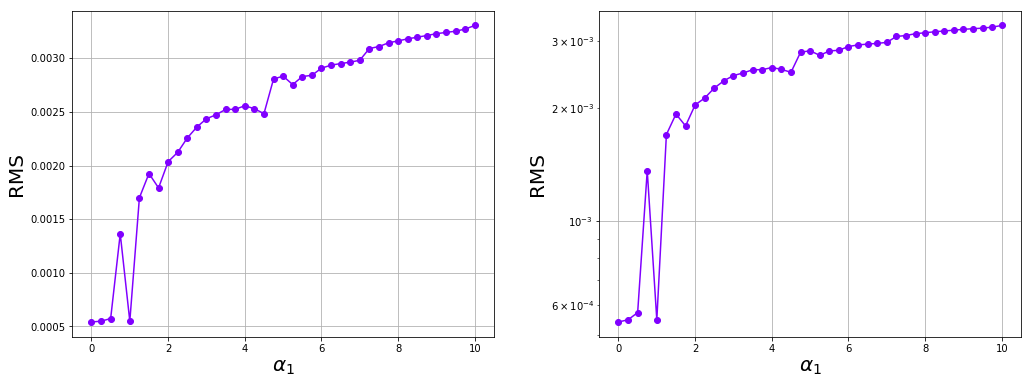

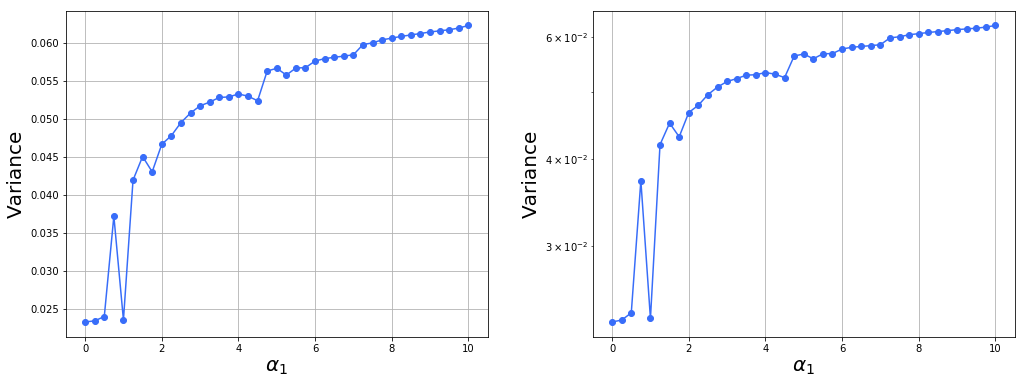

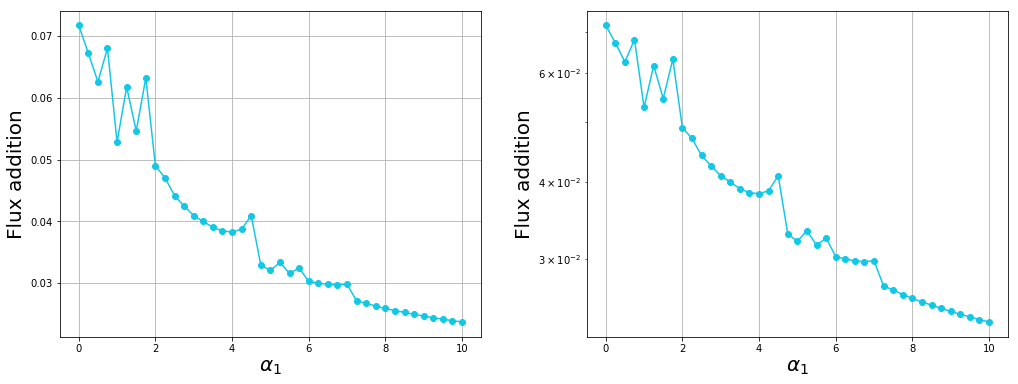

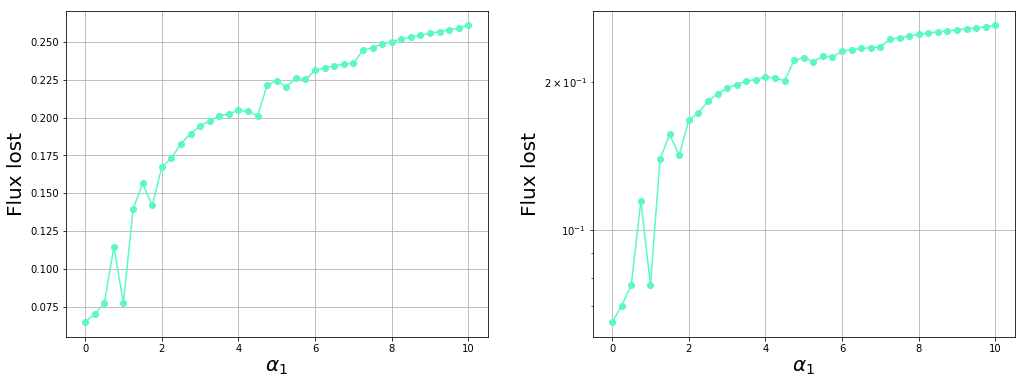

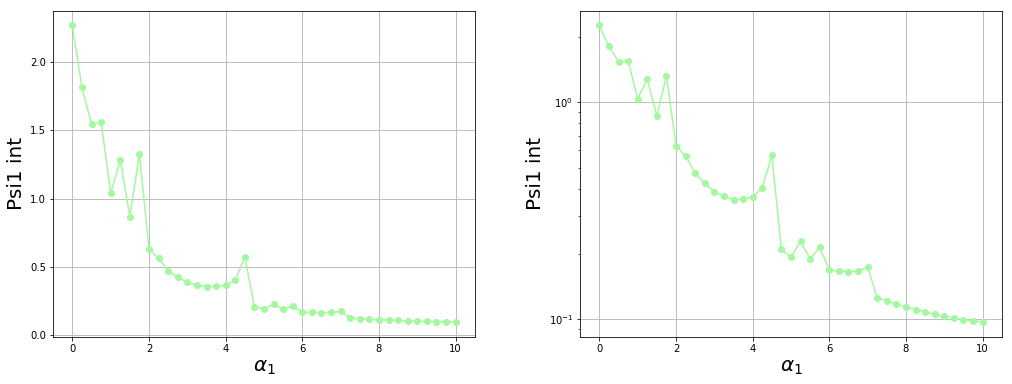

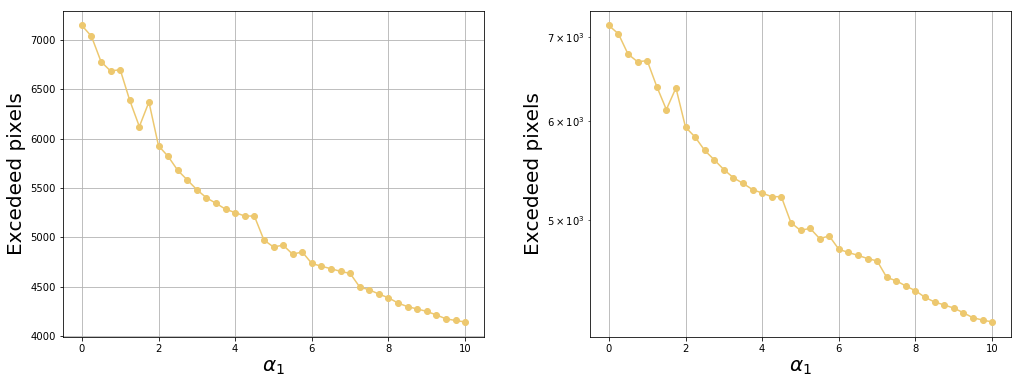

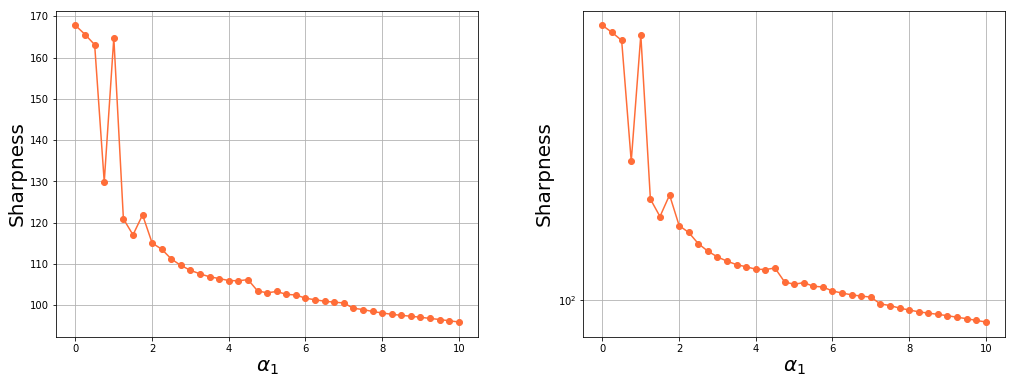

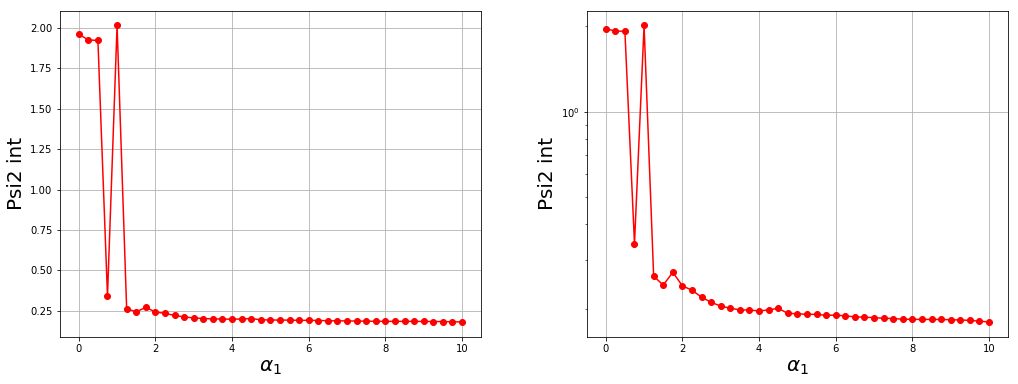

In [4]:
stats_plot(alpha1, r_stats, x_label=r'$\alpha_1$', loglog=False, slopes=[-2.,-1.,-1.,-1.,-1.,0.5,-0.5,-1.])

## `Case 2 `:   $\alpha_2 = [10^{-10},10^0]$ 

In [ ]:
elm_list = list()
#alpha2 = np.array([10**-n for n in range(0,11)])
alpha2 = np.linspace(1e-5, 1e-2, 20)

for a2 in alpha2:
    # common parameters
    minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
    maxsig = 30*minsig

    # number of points of each type
    Nc = 300
    Nb = int(0.2*Nc)
    Ne = 3*Nc - Nb
    
    # points generation
    points = qrandom_centers_generation(dfunc, Nc+Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[Nc:Nc+Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)

    # right format
    xc = center_points[:,0]
    yc = center_points[:,1]
    xe = collocation_points[:,0]
    ye = collocation_points[:,1]
    xb = boundary_points[:,0]
    yb = boundary_points[:,1]

    ## visualizing the choosen points
    #points_plot(data, center_points=center_points, title="Center Points")
    #points_plot(data, center_points=collocation_points, title="Collocation Points")


    ####################################
    # Initial parameters estimation
    ####################################
    c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')


    #solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
    #params_plot(c0, sig0, xc, yc)
    #params_distribution_plot(c0, sig0)
    elm_list.append( ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=0, lamb1=1., b=a2, lamb2=1.,
                    d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.) )

In [ ]:
for elm in elm_list:
    print('#'*90)
    print('Processing example with alpha2: {0}'.format(elm.b))
    print('#'*90 + '\n')
    nfev = 100*(len(elm.get_params())+1)
    elm_solver(elm, method='standard', max_nfev=nfev)
    # for memory reasons
    del elm.data; del elm.mask; del elm.dfunc
    
#pickling results
target = open("exp02_alpha2_m100.pkl", "wb")
pickle.dump(elm_list, target)
target.close()

### Analysis of results in `Orion KL`

In [5]:
elm_list = pickle.load( open('../results/exp02_alpha2_m100_0.pkl', 'rb') )

In [6]:
alpha2 = np.array( [elm.b for elm in elm_list] )
r_stats = [elm.residual_stats for elm in elm_list]

variance = np.array( [var for (var,_,_,_,_,_,_,_,_) in r_stats] )
entropy = np.array( [entr for (_,entr,_,_,_,_,_,_,_) in r_stats] )
rms = np.array( [rms for (_,_,rms,_,_,_,_,_,_) in r_stats] )
flux_addition = np.array( [flux for (_,_,_,flux,_,_,_,_,_) in r_stats] )
flux_lost = np.array( [flux for (_,_,_,_,flux,_,_,_,_) in r_stats] )
psi1_int = np.array( [psi1 for (_,_,_,_,_,psi1,_,_,_) in r_stats] )
npix = np.array( [npix for (_,_,_,_,_,_,npix,_,_) in r_stats] )
sharpness = np.array( [sharp for (_,_,_,_,_,_,_,sharp,_) in r_stats] )
psi2_int = np.array( [psi2 for (_,_,_,_,_,_,_,_,psi2) in r_stats] )

times = np.array([elm.elapsed_time for elm in elm_list])

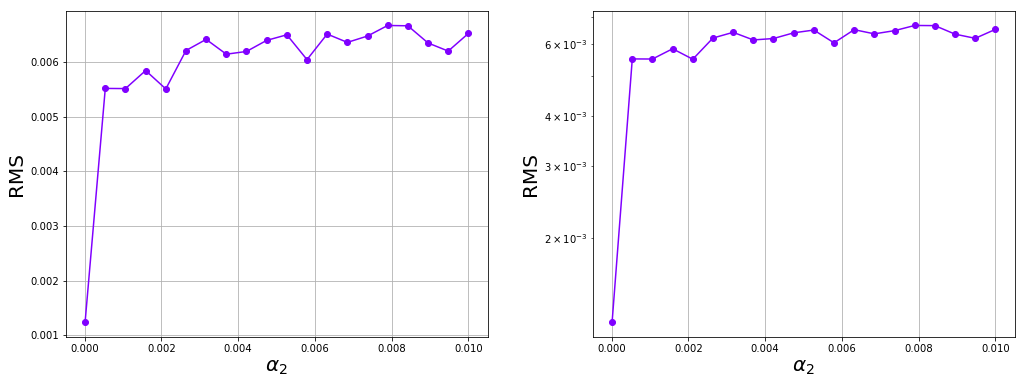

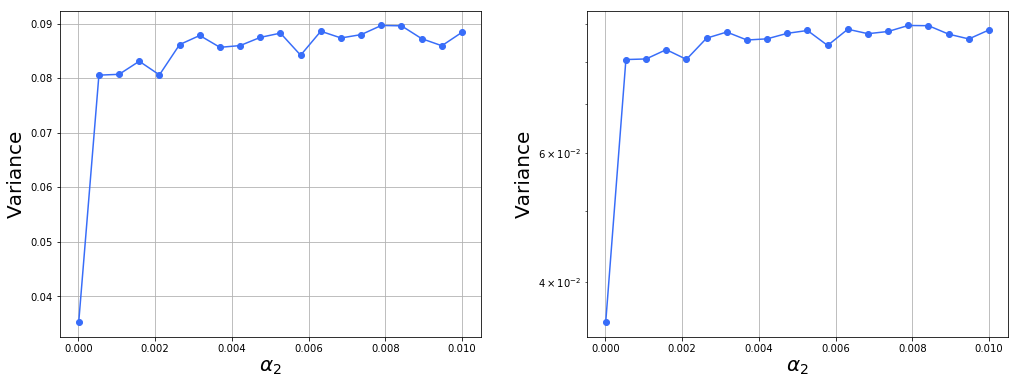

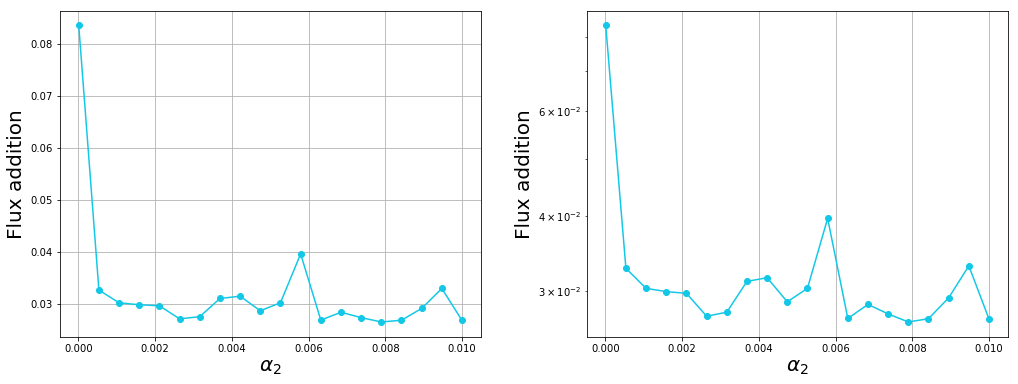

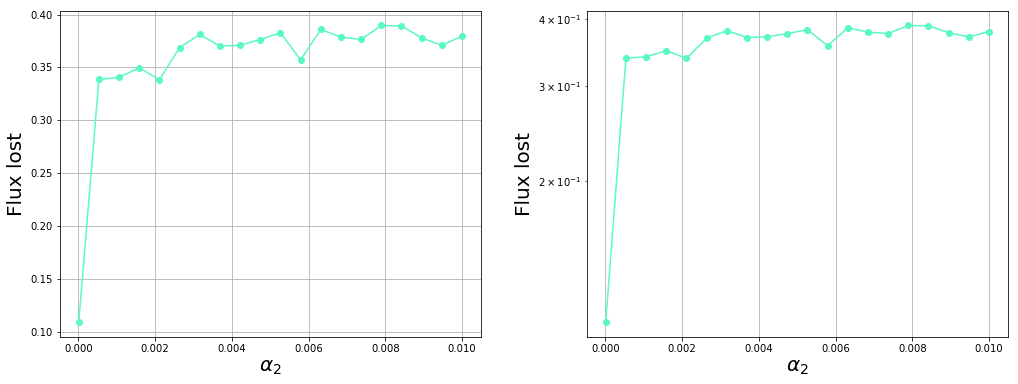

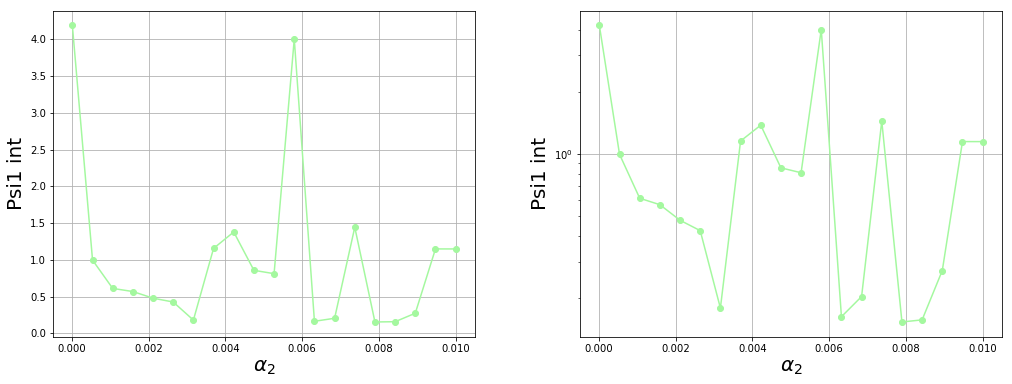

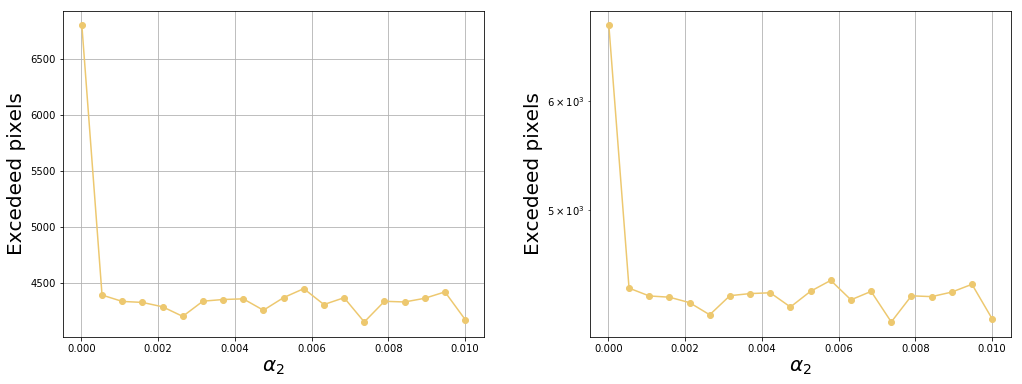

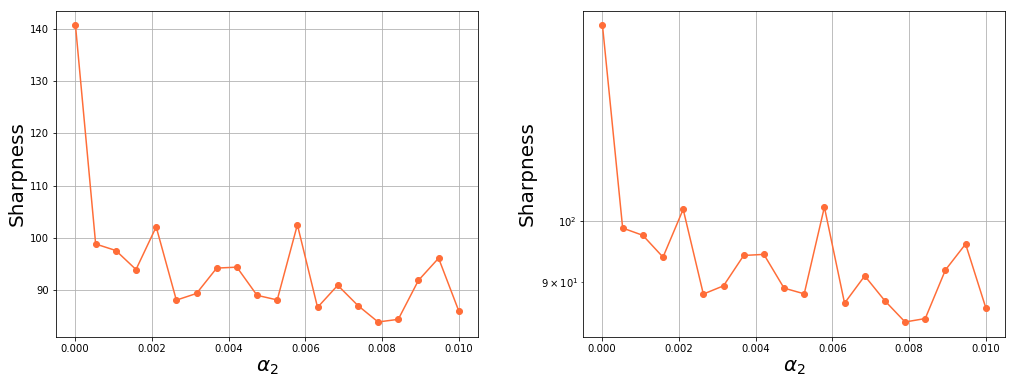

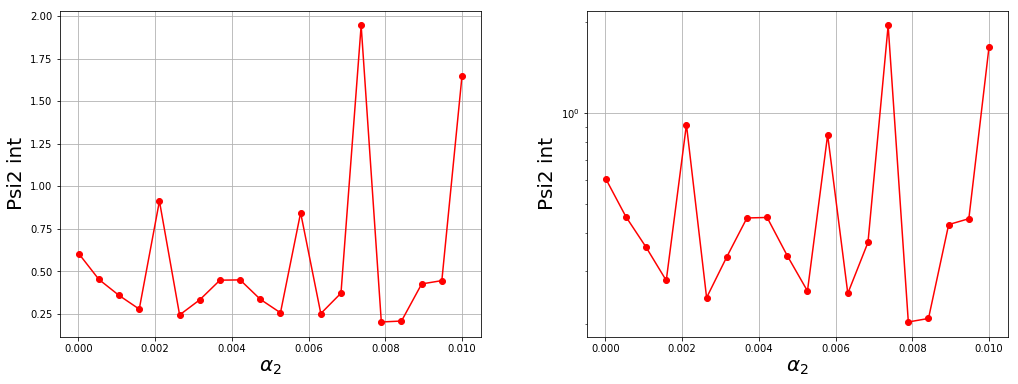

In [7]:
stats_plot(alpha2, r_stats, x_label=r'$\alpha_2$', loglog=False, slopes=[-2.,-1.,-1.,-1.,-1.,0.5,-0.5,-1.])